<img src="coin.jpg" width="600" height="200" align="right"/>

# Optimal Search (Thompson Sampling)

Author: Christoph Guettner

**Abstract**  
Thompson Sampling is used here to find the best of six   
coins with different winning probabilities p  
and 1-p. Thomson Sampling uses a prior and posterior  
Beta Distribution to solve the exploration exploitation   
Dilemma in an optimal way. Here, the results of four players   
within the same environment, however, with different  
prior beliefs and one random player are compared. 

<div style="text-align: right"> All content of the image belongs to Warner Bros. Animation (Batman) </div>



## Table of Contents
* [Loading and Preprocessing](#Loading_and_Preprocessing)
    * [Imports](#Imports)
    * [Classes and Functions](#Functions)

* [Define Environment](#Define_Environment)
    * [Probability](#Probability)

* [Define Players](#Define_Player1)
    * [Player1](#Define_Player1)
    * [Player2](#Define_Player2)
    * [Player3](#Define_Player3)
    * [Player4](#Define_Player4)

* [Define Random Player and Compare Results](#Define_Random_Player_and_compare_Results)
    * [Results](#Results)


    


In [7]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib.animation import FuncAnimation
from scipy.stats import beta

In [9]:
class Environment():
    """
    The class describes the game environment with six coins, the respective 
    winning probability (reward system) and the number of throws (1000)
    """
    def __init__(self, number_of_coins=6, number_of_throws=1000):
        self.index = None
        self.number_of_coins = number_of_coins
        self.number_of_throws = number_of_throws
        self.reward_system = np.zeros((self.number_of_throws, self.number_of_coins))
        self.reward_rate = None
        self._notYetCalled = True    

    def set_coin_probilities(self):
        if self._notYetCalled:
            self.reward_rate = np.random.uniform(0.20, 0.85, self.number_of_coins)
            self._notYetCalled = False

    def set_reward_rate(self):
        return self.reward_rate

    def print_coin_probabilities(self):
        for i in range(self.number_of_coins):
            print('Reward rate for coin {0}: {1:.2%}'.format(i, self.reward_rate[i]))


    def get_reward_system(self):
        return self.reward_system

    def generate_reward_system(self):
        for turn_index in range(self.number_of_throws): #for each turn
            for coin_index in range(self.number_of_coins): #for each coin
                #Get a random number between 0.0 and 1.0.
                if np.random.rand() <= self.reward_rate[coin_index]:
                    self.reward_system[turn_index][coin_index] = 1


class Player(Environment):
    """
    The class describes the player's the actions, beliefs, update function 
    and an individual sample from coin winning probability
    """
    def __init__(self, bias_a=1, bias_b=1):
        super().__init__()
        self.number_of_positive_rewards = np.zeros(self.number_of_coins)
        self.number_of_negative_rewards = np.zeros(self.number_of_coins)
        self.param_a = np.zeros((self.number_of_throws, self.number_of_coins))
        self.param_b = np.zeros((self.number_of_throws, self.number_of_coins))
        self.reward_system = np.zeros((self.number_of_throws, self.number_of_coins))
        self.bias_a = bias_a
        self.bias_b = bias_b
        self.actions = []
        self.total_wins_random_choice = 0

    def get_action_space(self):
        self.actions = list(np.arange(self.number_of_coins))
        return self.actions

    def get_prior_beliefs(self):
        return self.param_a[1,:], self.param_b[1,:]

    def get_posterior_beliefs(self):
        return self.param_a[-1,:], self.param_b[-1,:]

    def get_coins(self, coins):
        self.reward_rate = coins

    def sample_reward_system(self):
        super().generate_reward_system()


    def update_and_act(self, turn_index, max_beta):
        #determine which slot machine to play for this turn
        for coin_index in range(self.number_of_coins): #for each slot machine
            #Define the shape parameters for the beta distribution. The shape will depend on the number
            #of wins and losses that have thus far been observed for this particular slot machine.
            a = self.number_of_positive_rewards[coin_index] + self.bias_a + 1
            b = self.number_of_negative_rewards[coin_index] + self.bias_b + 1

            self.param_a[turn_index][coin_index]= a
            self.param_b[turn_index][coin_index]= b

            #Get a random value from the beta distribution whose shape is defined by the number of
            #wins and losses that have thus far been observed for this coin.
            random_beta = np.random.beta(a, b)
            #if this is the largest beta value thus far observed for this iteration
            if random_beta > max_beta:
                max_beta = random_beta #update the maximum beta value thus far observed
                index_of_choosen_coin = coin_index 

        return index_of_choosen_coin

    def play(self):
        #for each turn
        for turn_index in range(self.number_of_throws):
            index_of_coin_to_throw = -1
            max_beta = -1
            index_of_choosen_coin = self.update_and_act(turn_index, max_beta)

            #play the selected slot machine, and record whether we win or lose
            # if Environment.reward_system[turn_index][index_of_choosen_coin] == 1:
            if self.reward_system[turn_index][index_of_choosen_coin] == 1:
                self.number_of_positive_rewards[index_of_choosen_coin] += 1
            else:
                self.number_of_negative_rewards[index_of_choosen_coin] += 1
        return self.number_of_positive_rewards, self.number_of_negative_rewards


    def print_conclusion(self):
        number_of_times_played = self.number_of_positive_rewards + self.number_of_negative_rewards 
        for slot_machine_index in range(self.number_of_coins): #for each slot machine
            print('Coin {0} was thrown {1} times'.format(slot_machine_index, number_of_times_played[slot_machine_index]))

        #identify and display the best coin
        print('\nOverall Conclusion: The best coin is {}!'.format(np.argmax(number_of_times_played)))


        
    def choose_randomly(self):
        self.total_wins_random_choice = 0
        for turn_index in range(self.number_of_throws):
            chosen_coin = np.random.randint(0, self.number_of_coins) #randomly choose a coin to play
            if self.reward_system[turn_index][chosen_coin] == 1:
                self.total_wins_random_choice += 1
        return self.total_wins_random_choice, (self.number_of_throws - self.total_wins_random_choice)

# Plotting Functions

def plot_reward_probabilities(number_of_coins, reward_system):
    x = np.arange(number_of_coins)
    y = []
    plt.figure(figsize=(5, 5), facecolor='#3F6F76')
    for i in range(number_of_coins):
        mean = np.mean(reward_system[:, i])
        y.append(mean)
    plt.scatter(x, y, color='#C65840')
    plt.title('Reward Probability', color='0.7')
    plt.xlabel('Coins',color='0.7')
    plt.ylabel('Winning Rate',color='0.7')
    plt.show()

def show_results(prior_a, prior_b, posterior_a, posterior_b, title, subtitle):
    x = np.linspace(0,1, 100)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), facecolor='#3F6F76')
    fig.suptitle(title, color ='0.7')
    for i,ax in enumerate(axes.flatten()):
        prior = beta(int(prior_a[i]),int(prior_b[i]))
        post = beta(int(posterior_a[i]), int(posterior_b[i]))
        ax.plot(x, post.pdf(x), color='#4052BD', label='posterior')
        ax.plot(x, prior.pdf(x), color='#C65840', label='prior')
        ax.set_title(subtitle[i], color='0.7')
        ax.legend()
        

            

## Define_Environment

In [11]:
env = Environment()
rs = env.get_reward_system()

np.random.seed(12)

env.set_coin_probilities()
probability = env.set_reward_rate()

env.print_coin_probabilities()


Reward rate for coin 0: 30.02%
Reward rate for coin 1: 68.10%
Reward rate for coin 2: 37.12%
Reward rate for coin 3: 54.69%
Reward rate for coin 4: 20.95%
Reward rate for coin 5: 79.72%


## Define_Player1

Player1 has prior beliefs in form of a beta function with parameter a=1 and b=1

In [13]:
player1 = Player(1,1)
player1.get_coins(probability)
player1.get_action_space()

[0, 1, 2, 3, 4, 5]

### Create the Data Set

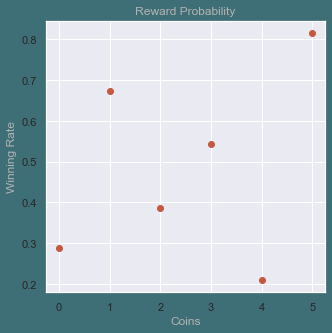

In [15]:
#define a seed for the random number generator (to ensure that results are reproducible)
player1.sample_reward_system()
number_of_coins= env.number_of_coins
reward_system = player1.get_reward_system()

plot_reward_probabilities(number_of_coins, reward_system)

In [17]:
print("Reward System Player1:")
print(reward_system[0:15, 0:6])



Reward System Player1:
[[0. 0. 1. 0. 1. 1.]
 [0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 1. 1. 1. 1. 1.]]


### Run the Game


In [19]:

Win1,Lose1 = player1.play()
player1.print_conclusion()


Coin 0 was thrown 4.0 times
Coin 1 was thrown 39.0 times
Coin 2 was thrown 16.0 times
Coin 3 was thrown 16.0 times
Coin 4 was thrown 10.0 times
Coin 5 was thrown 915.0 times

Overall Conclusion: The best coin is 5!


## Plot Beta Distribution

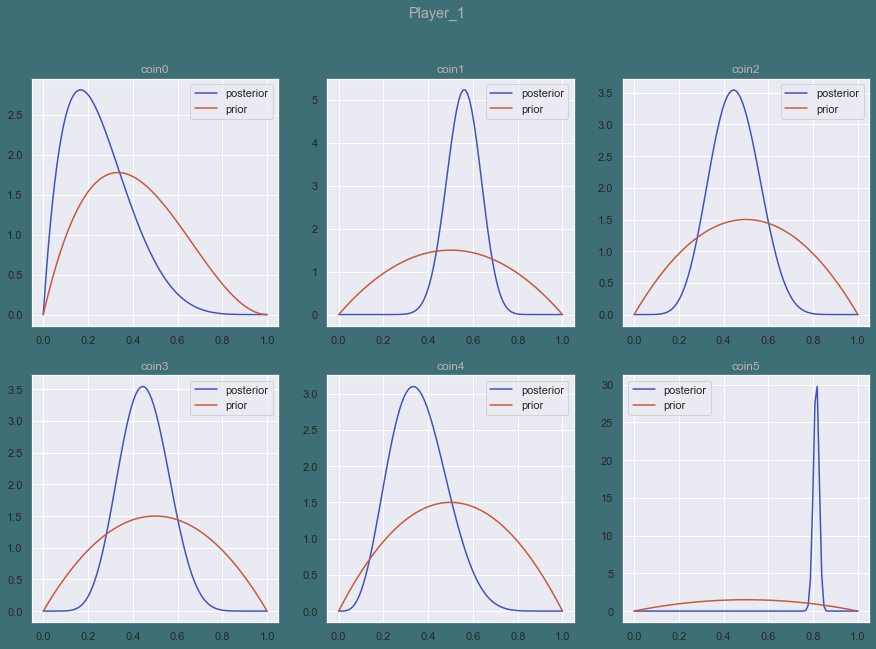

In [21]:
title='Player_1'
subtitle=['coin0','coin1','coin2','coin3','coin4','coin5']
prior_a, prior_b = player1.get_prior_beliefs()
posterior_a, posterior_b = player1.get_posterior_beliefs()


show_results(prior_a, prior_b, posterior_a, posterior_b, title, subtitle)

## Define_Player2

Player2 has prior beliefs in form of a beta function with parameters a=100 and b=100

In [23]:
player2 = Player(100,100)
player2.get_coins(probability)
player2.sample_reward_system()
reward_system = player2.get_reward_system()
Win2,Lose2 = player2.play()
player2.print_conclusion()


Coin 0 was thrown 22.0 times
Coin 1 was thrown 768.0 times
Coin 2 was thrown 21.0 times
Coin 3 was thrown 54.0 times
Coin 4 was thrown 23.0 times
Coin 5 was thrown 112.0 times

Overall Conclusion: The best coin is 1!


### Plot Beta Distribution

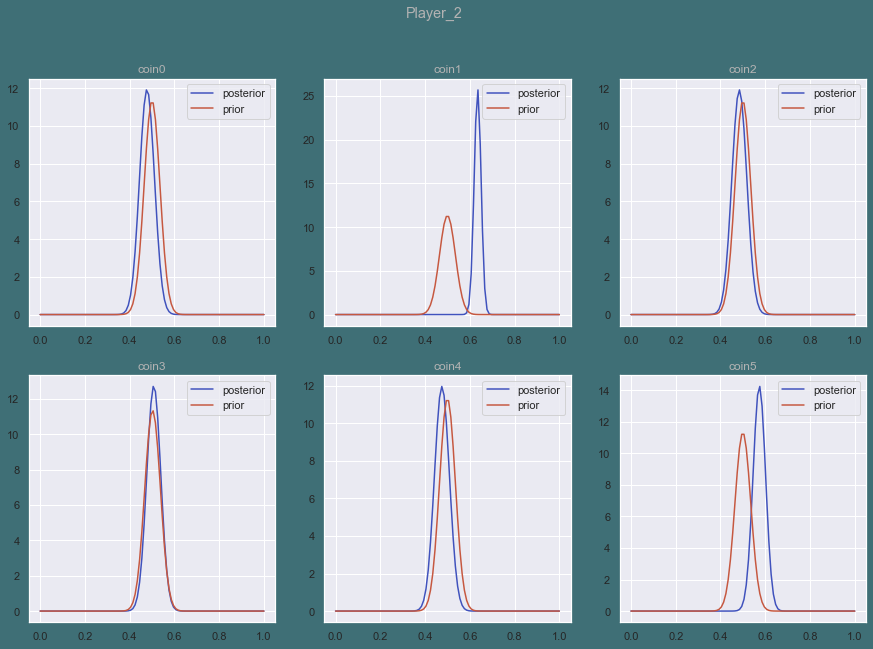

In [25]:
title='Player_2'
subtitle=['coin0','coin1','coin2','coin3','coin4','coin5']
prior_a, prior_b = player2.get_prior_beliefs()
posterior_a, posterior_b = player2.get_posterior_beliefs()

show_results(prior_a, prior_b, posterior_a, posterior_b, title, subtitle)

## Define_Player3

Player3 has prior beliefs in form of a beta function with parameter a=40 and b=1

In [27]:
player3 = Player(40,1)
player3.get_coins(probability)
player3.sample_reward_system()
reward_system = player3.get_reward_system()
Win3,Lose3 = player3.play()
player3.print_conclusion()

Coin 0 was thrown 33.0 times
Coin 1 was thrown 87.0 times
Coin 2 was thrown 31.0 times
Coin 3 was thrown 51.0 times
Coin 4 was thrown 26.0 times
Coin 5 was thrown 772.0 times

Overall Conclusion: The best coin is 5!


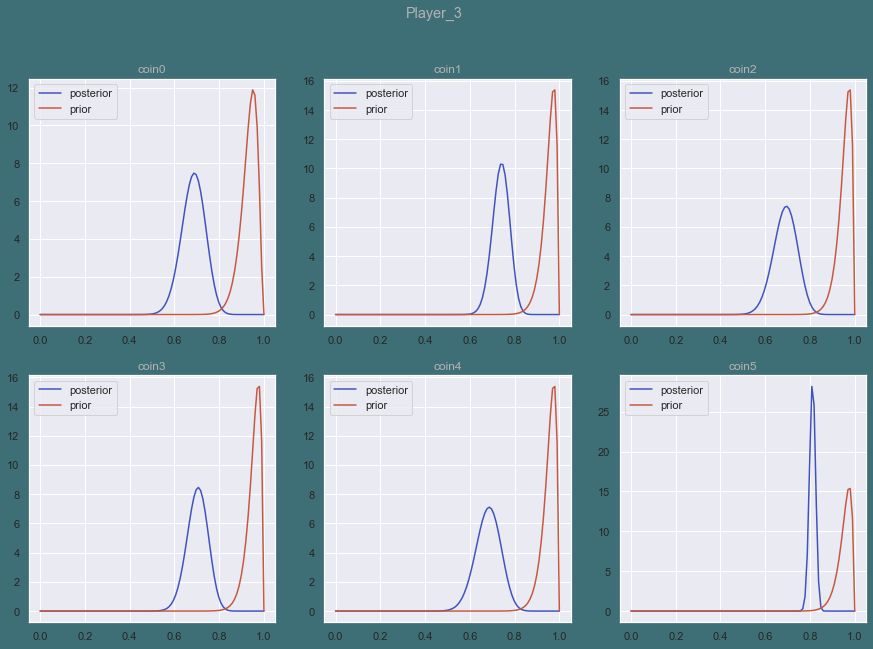

In [29]:
title='Player_3'
subtitle=['coin0','coin1','coin2','coin3','coin4','coin5']
prior_a, prior_b = player3.get_prior_beliefs()
posterior_a, posterior_b = player3.get_posterior_beliefs()

show_results(prior_a, prior_b, posterior_a, posterior_b, title, subtitle)

## Define_Player4

Player4 has prior beliefs in form of a beta function with parameter a=1 and b=40

In [ ]:
player4 = Player(1,40)
player4.get_coins(probability)
player4.sample_reward_system()
reward_system = player4.get_reward_system()
Win4,Lose4 = player4.play()
player4.print_conclusion()

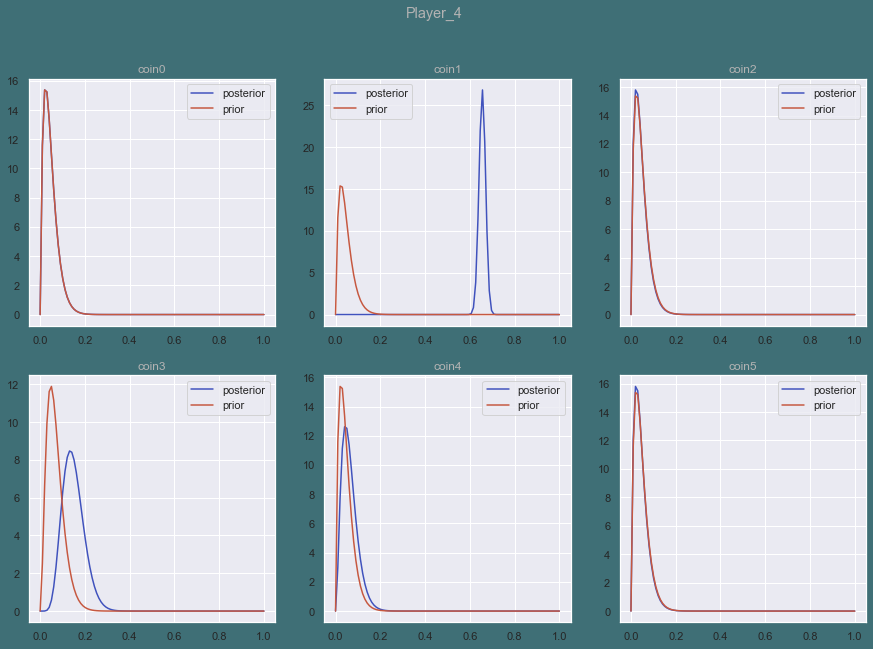

In [24]:
title='Player_4'
subtitle=['coin0','coin1','coin2','coin3','coin4','coin5']
prior_a, prior_b = player4.get_prior_beliefs()
posterior_a, posterior_b = player4.get_posterior_beliefs()

show_results(prior_a, prior_b, posterior_a, posterior_b, title, subtitle)

## Define_Random_Player_and_Compare_Results

In [26]:
Win1 = np.sum(Win1)
Win2 = np.sum(Win2)
Win3 = np.sum(Win3)
Win4 = np.sum(Win4)

In [28]:
win_random, lose_random = player1.choose_randomly()

In [30]:

#display results
print('Player1 wins with Thompson Sampling: {0:.0f}'.format(Win1))
print('Player2 wins with Thompson Sampling: {0:.0f}'.format(Win2))
print('Player3 wins with Thompson Sampling: {0:.0f}'.format(Win3))
print('Player4 wins with Thompson Sampling: {0:.0f}'.format(Win4))
print('Player wins with Random Sampling: {0:.0f}'.format(win_random))

Player1 wins with Thompson Sampling: 784
Player2 wins with Thompson Sampling: 641


TypeError: unsupported format string passed to numpy.ndarray.__format__